In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt

from pathlib import Path
import shutil
import rasterio
#from rasterio.transform import from_bounds
#from rasterio.transform import from_gcps
#from rasterio.control import GroundControlPoint
#from rasterio.warp import reproject, Resampling
#from rasterio.crs import CRS
import pyproj
from datetime import datetime

from scipy.ndimage import distance_transform_edt

km = 1000

In [2]:
def tiff_to_geotiff(tiff_file, 
                    output_file, 
                    target_crs = 'EPSG:3031', 
                    corners=[(-3500*1000, 3500*1000), 
                             (3500*1000, 3500*1000), 
                             (3500*1000, -3500*1000), 
                             (-3500*1000, -3500*1000)]):
    """
    Converts a regular TIFF to GeoTIFF by adding spatial metadata.
    Preserves aspect ratio of the input raster.
    
    Args:
        tiff_file (str): Input TIFF file path
        output_file (str): Output GeoTIFF file path  
        corners (list): Four (lat, lon) tuples: UL, UR, LR, LL
    """
    with rasterio.open(tiff_file) as src:
        # Read the data and get dimensions
        data = src.read()
        height, width = src.height, src.width
        
        # Calculate aspect ratio of the raster
        aspect_ratio = width / height
        
        # Extract coordinates from corners (UL, UR, LR, LL)
        ul_lat, ul_lon = corners[0]  # Upper Left
        ur_lat, ur_lon = corners[1]  # Upper Right  
        lr_lat, lr_lon = corners[2]  # Lower Right
        ll_lat, ll_lon = corners[3]  # Lower Left
        
        # Calculate the full extent from corners
        west = min(ul_lon, ll_lon)
        east = max(ur_lon, lr_lon)
        north = max(ul_lat, ur_lat)
        south = min(ll_lat, lr_lat)
        
        # Full extent dimensions
        full_width = east - west
        full_height = north - south
        
        # Determine which dimension is longer in the raster
        if width >= height:  # Width is longer or equal
            # Keep full width, scale height by aspect ratio
            actual_width = full_width
            actual_height = full_width / aspect_ratio
        else:  # Height is longer
            # Keep full height, scale width by aspect ratio  
            actual_height = full_height
            actual_width = full_height * aspect_ratio
        
        # Centre the scaled extent within the full extent
        center_x = (west + east) / 2
        center_y = (south + north) / 2
        
        # Calculate new bounds preserving aspect ratio
        new_west = center_x - actual_width / 2
        new_east = center_x + actual_width / 2
        new_south = center_y - actual_height / 2
        new_north = center_y + actual_height / 2
        
        # Create transform from bounds
        transform = from_bounds(new_west, new_south, new_east, new_north, width, height)
        
        # Update profile with spatial information
        profile = src.profile.copy()
        profile.update({
            'driver': 'GTiff',
            'crs': target_crs,  # Antarctic Polar Stereographic
            'transform': transform
        })
        
        # Write to new GeoTIFF
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(data)



In [4]:
# This Cell checks if there is agreement between the files listed in Atlas Master and existing files in the extraction dir


# Modified main processing function
df = pd.read_excel('atlas_master_v_0_9.xlsx')
tie_points_source = Path('geo_ref/tie_points.gpkg')
raw_dir = Path('maps/raw/')
geotiff_dir = Path('maps/geotiff/')

km = 1000  # Define km constant

extracted_maps = [p.name for p in raw_dir.iterdir() if p.is_file() and p.name[-5:] == '.tiff']

len(extracted_maps)

map_paths_df = (
    df['path']
    .replace(['-', '.DS_Store'], pd.NA)          
    .dropna()                    
    .str.split(',')              
    .explode()               
    .str.strip()                 
    .tolist()
)

map_names_df = [Path(x).name for x in map_paths_df]

extracted_set = set(extracted_maps)
map_paths_df_set = set(map_names_df)


missing_extracted_maps = list(map_paths_df_set - extracted_set)

maps_not_in_df = list(extracted_set - map_paths_df_set)

print('Missing maps: ', len(missing_extracted_maps))
print(sorted(missing_extracted_maps))

print()

print('Missing entries: ', len(maps_not_in_df))
print(maps_not_in_df)

Missing maps:  0
[]

Missing entries:  0
[]


In [5]:
# Copy files to designated directories. 

geotiff_dir = Path('maps/geotiff/')
tie_points_source = Path('geo_ref/tie_points.gpkg')

# Parse and explode paths
map_paths_list = (
    df['path']
    .replace(['-', '.DS_Store'], pd.NA)          
    .dropna()                    
    .str.split(',')              
    .explode()               
    .str.strip()                 
)

# Track results
extraction_results = {}  # {original_path: [(file_stem, success, tiepoint_path, raw_path), ...]}
missing_files = []

# Process each path
for idx, path_str in map_paths_list.items():
    if path_str not in extraction_results:
        extraction_results[path_str] = []
    
    path = Path(path_str)
    file_stem = path.stem  # e.g., 'P_31_I'
    
    # Create target directory
    target_dir = path.parent / f"{file_stem}_georeferencing"
    target_dir.mkdir(parents=True, exist_ok=True)
    
    # Paths for target files
    tiepoint_path = target_dir / f"{file_stem}.gpkg"
    geotiff_path = geotiff_dir / f"{file_stem}.tiff"
    raw_path = target_dir / f"{file_stem}.tiff"
    
    # Check if geotiff exists
    if not geotiff_path.exists():
        missing_files.append(str(geotiff_path))
        print(f"ERROR: GeoTIFF not found: {geotiff_path}")
        extraction_results[path_str].append((file_stem, False, None, None))
        continue
    
    # Copy files (preserve existing)
    success = True
    
    # Copy/preserve tie points
    if not tiepoint_path.exists():
        try:
            shutil.copy2(tie_points_source, tiepoint_path)
        except Exception as e:
            print(f"ERROR copying tie points for {file_stem}: {e}")
            success = False
    
    # Copy/preserve geotiff
    if not raw_path.exists():
        try:
            shutil.copy2(geotiff_path, raw_path)
        except Exception as e:
            print(f"ERROR copying geotiff for {file_stem}: {e}")
            success = False
    
    extraction_results[path_str].append((
        file_stem, 
        success, 
        str(tiepoint_path), 
        str(raw_path)
    ))
    
    if success:
        print(f"✓ Processed {file_stem}")
    else:
        print(f"✗ Failed to process {file_stem}")

# Update dataframe
df['tiepoint_path'] = df['path'].apply(
    lambda x: ', '.join([
        result[2] for result in extraction_results.get(x, []) if result[2]
    ]) if x in extraction_results else '-'
)

df['raw_path'] = df['path'].apply(
    lambda x: ', '.join([
        result[3] for result in extraction_results.get(x, []) if result[3]
    ]) if x in extraction_results else '-'
)

df['Extracted'] = df['path'].apply(
    lambda x: 'yes' if all(result[1] for result in extraction_results.get(x, [])) 
              and len(extraction_results.get(x, [])) > 0
              else '-'
)

# Report missing files
if missing_files:
    print("\n" + "="*60)
    print("MISSING GEOTIFF FILES:")
    print("="*60)
    for f in sorted(set(missing_files)):
        print(f"  {f}")
    print(f"\nTotal missing: {len(set(missing_files))}")


✓ Processed P_7_I
✓ Processed P_7_II
✓ Processed P_7_II_A
✓ Processed P_7_II_B
✓ Processed P_8_III
✓ Processed P_8_III_A
✓ Processed P_8_III_B
✓ Processed P_8_IV
✓ Processed P_8_IV_A
✓ Processed P_9_VI
✓ Processed P_9_VI_B
✓ Processed P_9_VI_V
✓ Processed P_9_VI_G
✓ Processed P_10-11_VIIa
✓ Processed P_10-11_VIIb
✓ Processed P_12_VIII
✓ Processed P_12_IX
✓ Processed P_12_IX_A
✓ Processed P_13-14_Ia
✓ Processed P_13-14_Ib
✓ Processed P_13-14_I_A
✓ Processed P_13-14_I_B
✓ Processed P_13-14_I_V
✓ Processed P_15_II
✓ Processed P_15_III
✓ Processed P_16-17_Ia
✓ Processed P_16-17_Ib
✓ Processed P_18_II
✓ Processed P_19_T
✓ Processed P_19-20_IIIa
✓ Processed P_19-20_IIIb
✓ Processed P_21_IV
✓ Processed P_22_V
✓ Processed P_23_VI
✓ Processed P_24_VII
✓ Processed P_25_I_V
✓ Processed P_25_I_G
✓ Processed P_25_I_D
✓ Processed P_25_I_Ye
✓ Processed P_25_I_Zh
✓ Processed P_25_I_Z
✓ Processed P_25_I_I
✓ Processed P_25_I_K
✓ Processed P_26_II_V
✓ Processed P_26_II_G
✓ Processed P_26_II_D
✓ Processed

In [8]:
df.to_excel('atlas_master_0_9_5.xlsx')

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


497

In [128]:
# This Cell change all teh raw ingaes to (ungeorefreneced) 


raw_dir = Path('maps/raw/')
geotiff_dir = Path('maps/geotiff/')
tie_points_source = Path('geo_ref/tie_points.gpkg')

geotiff_dir.mkdir(parents=True, exist_ok=True)

for img_file in extracted_maps:
    source = raw_dir / img_file
    dest_tiff = geotiff_dir / img_file
    dest_gpkg = dest_tiff.with_suffix('.gpkg')
    
    try:
        tiff_to_geotiff(str(source), str(dest_tiff))
        shutil.copy2(tie_points_source, dest_gpkg)
    except Exception as e:
        print(f"Error processing {img_file}: {e}")
# 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [30]:
# raw_dir = Path('maps/raw/')
# geotiff_dir = Path('maps/geotiff/')
# tie_points_source = Path('geo_ref/tie_points.gpkg')

# geotiff_dir.mkdir(parents=True, exist_ok=True)

# for img_file in extracted_maps:
#     source = raw_dir / img_file
#     dest_tiff = geotiff_dir / img_file
#     dest_gpkg = dest_tiff.with_suffix('.gpkg')
    
#     try:
#         tiff_to_geotiff(str(source), str(dest_tiff))
#         shutil.copy2(tie_points_source, dest_gpkg)
#     except Exception as e:
#         print(f"Error processing {img_file}: {e}")


Error processing .DS_Store: 'maps/raw/.DS_Store' not recognized as being in a supported file format.


In [117]:
geotiff_dir = Path('maps/geotiff/')
fail_count = 0
success_count = 0

# Optional: projections dict (for future use)
projections = {}  # Format: {'P_145_Ia': 'epsg:1234'}
default_crs = 3031

for filename in geotiff_dir.iterdir():
    if not filename.is_file() or filename.suffix != '.tiff':
        continue
    
    stem = filename.stem
    
    # Find the corresponding path in map_paths_df
    dest_path = None
    for p in map_paths_df:
        if Path(p).name == filename.name:
            dest_path = Path(p)
            break
    
    if dest_path is None:
        print(f"Error: {filename.name} not found in map_paths_df")
        fail_count += 1
        continue
    
    # Paths for inputs and outputs
    source_raster = geotiff_dir / filename.name
    target_raster = dest_path
    tie_points_gpkg = geotiff_dir / f"{stem}.gpkg"
    
    # Get CRS from dict or use default
    # Handle both string 'epsg:3031' and integer 3031 formats
    proj_val = projections.get(stem, default_crs)
    if isinstance(proj_val, str):
        crs = int(proj_val.split(':')[1])
    else:
        crs = int(proj_val)
    
    # Georeference
    try:
        target_raster.parent.mkdir(parents=True, exist_ok=True)
        log_file = georeference_map(str(source_raster), str(target_raster), 
                                     str(tie_points_gpkg), target_crs=crs)
        success_count += 1
        
        georef_subdir = dest_path.parent / f"{stem}_georeferencing"
        georef_subdir.mkdir(parents=True, exist_ok=True)
        
        # Copy log file
        shutil.copy2(log_file, georef_subdir / log_file.name)
        
        # Copy original GPKG (from maps/geotiff/)
        shutil.copy2(tie_points_gpkg, georef_subdir / f"{stem}.gpkg")
        
        # Copy original ungeoreferenced GeoTIFF (from maps/geotiff/)
        shutil.copy2(source_raster, georef_subdir / filename.name)
        
    except Exception as e:
        print(f"Error georeferencing {filename.name}: {e}")
        fail_count += 1

print(f"\nGeoreferencing complete:")
print(f"  Successful: {success_count}")
print(f"  Failed: {fail_count}")


Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_105_VI.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_105_VI.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4145 x 4808 pixels
Point 1: pixel(108.0,437.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4056.6,454.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4043.3,4298.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-152.0,3851.0) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2073.3,2368.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(360.2,2359.3) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2088.7,367.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3795.3,2375.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2072.3,4363.9) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2074.1,3369.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2935.0,2371.9) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1218.9,2363.6) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_75_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4126 x 4803 pixels
Point 1: pixel(100.6,436.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4045.1,454.3) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4031.8,4294.4) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-159.2,3847.0) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2063.8,2365.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(352.5,2356.8) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2079.2,366.7) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3784.0,2373.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2062.8,4359.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2064.6,3366.4) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2924.6,2369.4) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1210.3,2361.2) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_138_II_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_38_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 2079 x 2429 pixels
Point 1: pixel(47.0,220.8) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2041.9,229.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2035.1,2171.8) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-84.3,1945.5) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1039.9,1196.3) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(174.5,1191.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1047.7,185.4) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1909.8,1200.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1039.4,2204.6) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(1040.3,1702.5) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(1475.3,1198.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(608.3,1194.1) → EP

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_97-98_Ib.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8262 x 5191 pixels
Point 1: pixel(755.3,-784.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7540.5,-754.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7517.6,5851.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(308.4,5081.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4132.4,2533.7) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1188.7,2518.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4158.8,-904.7) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7091.4,2547.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4130.7,5963.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4133.8,4255.3) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5613.2,2540.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2664.2,2526.1

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_178_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5325 x 3889 pixels
Point 1: pixel(486.8,-233.8) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4860.0,-214.4) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4845.2,4043.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(198.8,3547.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2663.4,1904.7) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(766.1,1895.0) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2680.4,-311.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4570.5,1913.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2662.3,4115.2) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2664.3,3014.3) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3617.8,1908.9) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1717.2,1899.8)

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_163-164_Ib.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5181 x 8279 pixels
Point 1: pixel(-792.2,752.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(6007.0,783.0) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(5984.1,7402.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-1240.0,6631.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2591.9,4077.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-357.9,4062.5) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2618.4,632.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(5557.0,4091.0) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2590.2,7514.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2593.3,5802.7) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(4075.7,4084.2) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1120.7,4070.0

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_224_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/51_pacific_sector_ross_sea_and_bellingshausen_sea_p_208-225/maps/P_224_V.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_149_II.gpkg
Source raster: 4158 x 3307 pixels
Point 1: pixel(380.1,-47.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3794.9,-32.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3783.4,3292.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(155.2,2904.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2079.7,1622.4) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(598.2,1614.8) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2093.0,-108.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3568.9,1629.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2078.8,3348.4) → EPSG3031 current(-285,-2853438) t

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_149_II.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/12_continent_and_islands/44_mac_robertson_land_and_princess_elizabeth_land_p_142-151/maps/P_149_II.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_224_VII.gpkg
Source raster: 2405 x 2040 pixels
Point 1: pixel(219.9,36.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2195.0,45.0) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2188.3,1967.8) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(89.8,1743.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1202.9,1002.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(346.0,997.6) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1210.6,1.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2064.2,1005.9) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1202.4,2000.4) → EPSG3031 current(-285,-2853438)

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_224_VII.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/51_pacific_sector_ross_sea_and_bellingshausen_sea_p_208-225/maps/P_224_VII.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_23_VI.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_23_VI.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8443 x 5092 pixels
Point 1: pixel(771.8,-907.8) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7705.7,-876.9) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7682.3,5873.5) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(315.1,5086.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4222.9,2482.9) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1214.7,2467.5) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4249.9,-1030.9) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7246.7,2496.5) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4221.2,5987.7) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4224.4,4242.2) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5736.1,2489.6) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2722.6,2475.

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_196-197_Vb.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 7136 x 8244 pixels
Point 1: pixel(199.6,749.6) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(6970.0,779.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(6947.2,7371.0) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-246.3,6603.0) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(3569.4,4060.4) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(632.1,4045.3) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(3595.7,629.4) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(6521.9,4073.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(3567.7,7482.5) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(3570.8,5778.2) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5046.9,4066.9) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2104.4,4052.8) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_176_VI_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/12_continent_and_islands/47_ellsworth_land_and_antarctic_peninsula_p_172-177/maps/P_176_VI_A.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_32_III.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_32_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4211 x 4813 pixels
Point 1: pixel(139.0,437.6) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4091.7,455.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4078.4,4303.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-121.4,3855.0) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2106.3,2370.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(391.5,2361.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2121.7,367.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3830.0,2378.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2105.3,4368.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2107.1,3373.4) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2968.9,2374.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1251.0,2366.1) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_166-167_IIIb.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5177 x 8255 pixels
Point 1: pixel(-784.4,750.6) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(5995.1,780.8) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(5972.2,7380.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-1230.9,6611.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2589.9,4065.8) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-351.3,4050.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2616.3,630.2) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(5546.4,4079.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2588.2,7492.5) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2591.3,5785.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(4069.4,4072.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1123.0,4058.2

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_207_XV_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/50_indian_sector_and_davis_sea_p_190-207/maps/P_207_XV_A.tiff
Error: P_214-215_IVa.tiff not found in map_paths_df
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_168_IV_B.gpkg
Source raster: 2418 x 3353 pixels
Point 1: pixel(-161.0,304.9) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2592.7,317.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2583.4,2997.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-342.4,2685.6) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1209.5,1651.4) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(14.9,1645.3) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1220.3,256.0) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2410.4,1656.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1208.9,3043.

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_168_IV_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/12_continent_and_islands/45_wilkes_land_p_152-168/maps/P_168_IV_B.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_151-152_I_A.gpkg
Source raster: 4169 x 4569 pixels
Point 1: pixel(217.7,415.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3970.0,432.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3957.3,4085.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-29.5,3659.5) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2085.2,2250.3) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(457.4,2242.0) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2099.9,348.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3721.6,2257.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2084.3,4147.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Poi

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_151-152_I_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/12_continent_and_islands/44_mac_robertson_land_and_princess_elizabeth_land_p_142-151/maps/P_151-152_I_A.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_80_IV_A.gpkg
Source raster: 1713 x 1731 pixels
Point 1: pixel(149.2,157.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1570.8,163.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1566.0,1547.7) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(55.6,1386.4) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(856.8,852.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(240.0,849.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(862.3,132.2) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1476.7,855.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(856.4,1571.1) → EPSG3031 current(-285,-2853

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_80_IV_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_144_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8293 x 4793 pixels
Point 1: pixel(758.1,-996.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7568.8,-965.6) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7545.8,5664.8) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(309.5,4892.3) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4147.9,2334.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1193.2,2319.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4174.4,-1116.9) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7118.0,2347.9) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4146.2,5777.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4149.3,4062.6) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5634.2,2341.1) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2674.2,2326.

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_188_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/49_atlantic_sector_and_weddell_sea_p_181-189/maps/P_188_IV.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_26_II_I.gpkg
Source raster: 1594 x 1821 pixels
Point 1: pixel(53.0,165.6) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1548.5,172.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1543.4,1628.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-45.5,1458.5) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(797.3,896.9) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(148.5,893.6) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(803.1,139.0) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1449.5,899.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(796.9,1652.8) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Poi

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_26_II_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_91_I_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 2534 x 2521 pixels
Point 1: pixel(231.6,223.9) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2312.7,233.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2305.7,2259.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(94.6,2023.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1267.4,1241.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(364.6,1236.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1275.5,187.0) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2175.0,1245.6) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1266.9,2293.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(1267.9,1769.6) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(1721.6,1243.6) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(817.1,1239.2) → EP

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_142_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4824 x 6095 pixels
Point 1: pixel(-78.3,554.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4927.2,576.5) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4910.3,5449.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-408.0,4881.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2413.0,3001.9) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(241.4,2990.8) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2432.5,465.3) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4595.9,3011.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2411.8,5532.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2414.1,4272.0) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3505.4,3006.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1330.0,2996.3) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_139_III_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_151-152_Ib.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5233 x 8338 pixels
Point 1: pixel(-790.3,758.1) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(6057.3,788.6) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(6034.3,7455.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-1241.3,6678.3) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2617.9,4106.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-352.9,4091.5) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2644.6,636.6) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(5604.1,4120.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2616.2,7567.9) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2619.3,5844.1) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(4112.3,4113.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1136.3,4099.0

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_8_III_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_171_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 2424 x 4145 pixels
Point 1: pixel(-481.6,376.9) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2922.5,392.0) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2911.0,3706.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-705.8,3319.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1212.7,2041.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-264.1,2033.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1225.9,316.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2697.2,2048.2) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1211.8,3762.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(1213.4,2905.2) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(1955.6,2044.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(476.1,2037.7) 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_116_XVIII.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4125 x 4799 pixels
Point 1: pixel(101.7,436.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4042.9,453.9) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4029.6,4290.8) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-157.9,3843.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2063.3,2363.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(353.5,2354.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2078.6,366.4) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3782.0,2371.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2062.3,4355.7) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2064.1,3363.6) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2923.4,2367.4) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1210.5,2359.2) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_187_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4823 x 4110 pixels
Point 1: pixel(440.9,82.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4401.8,99.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4388.5,3955.8) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(180.0,3506.5) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2412.3,2018.9) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(693.9,2010.1) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2427.7,11.7) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4139.6,2026.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2411.3,4021.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2413.1,3023.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3276.7,2022.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1555.3,2014.5) → EPS

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_16-17_Ib.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8291 x 5172 pixels
Point 1: pixel(757.9,-805.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7566.9,-775.3) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7544.0,5853.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(309.5,5081.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4146.9,2524.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1192.9,2508.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4173.4,-926.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7116.3,2537.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4145.2,5965.7) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4148.3,4251.7) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5632.9,2530.6) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2673.6,2516.4

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_76_II.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4140 x 4814 pixels
Point 1: pixel(103.1,437.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4056.6,455.3) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4043.3,4304.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-157.3,3855.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2070.8,2371.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(355.6,2362.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2086.2,367.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3794.9,2378.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2069.8,4369.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2071.6,3374.1) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2933.6,2374.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1215.4,2366.6) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_66_II.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4844 x 4179 pixels
Point 1: pixel(442.8,107.9) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4421.0,125.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4407.6,3998.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(180.8,3547.3) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2422.8,2053.3) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(696.9,2044.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2438.3,37.3) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4157.7,2061.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2421.8,4064.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2423.7,3062.7) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3291.0,2057.1) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1562.0,2048.8) → E

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_37_VII.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4122 x 4804 pixels
Point 1: pixel(98.2,436.8) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4043.5,454.4) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4030.2,4295.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-161.7,3847.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2061.8,2366.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(350.2,2357.3) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2077.2,366.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3782.3,2373.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2060.8,4360.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2062.6,3367.1) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2922.8,2369.9) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1208.1,2361.7) → 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_203_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/50_indian_sector_and_davis_sea_p_190-207/maps/P_203_IV.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_221_VIII.gpkg
Source raster: 2375 x 2036 pixels
Point 1: pixel(217.1,46.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2167.6,55.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2161.0,1954.0) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(88.6,1732.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1187.9,1000.2) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(341.7,995.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1195.5,11.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2038.5,1004.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1187.4,1986.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Poin

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_221_VIII.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/51_pacific_sector_ross_sea_and_bellingshausen_sea_p_208-225/maps/P_221_VIII.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_213_IV.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_213_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8314 x 4789 pixels
Point 1: pixel(760.0,-1006.6) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7587.9,-976.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7564.9,5671.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(310.3,4896.6) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4158.4,2332.3) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1196.2,2317.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4185.0,-1127.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7136.0,2345.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4156.7,5783.6) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4159.8,4064.8) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5648.5,2339.0) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2681.0,2324

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_139_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 7126 x 4845 pixels
Point 1: pixel(651.4,-492.6) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(6503.7,-466.5) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(6484.0,5230.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(266.0,4567.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(3564.2,2369.2) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1025.3,2356.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(3587.0,-596.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(6116.3,2380.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(3562.7,5327.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(3565.4,3854.1) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(4841.4,2374.9) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2297.9,2362.7

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_73_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4120 x 4813 pixels
Point 1: pixel(93.5,437.6) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4046.2,455.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4032.9,4303.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-166.9,3855.0) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2060.8,2370.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(346.0,2361.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2076.2,367.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3784.5,2378.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2059.8,4368.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2061.6,3373.4) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2923.4,2374.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1205.5,2366.1) → 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_21_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8250 x 4813 pixels
Point 1: pixel(754.2,-968.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7529.5,-938.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7506.7,5657.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(307.9,4889.3) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4126.4,2344.8) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1187.0,2329.8) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4152.8,-1088.7) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7081.1,2358.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4124.7,5769.5) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4127.8,4063.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5605.0,2351.4) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2660.4,2337.

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_117_XX.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/9_waters_of_the_southern_ocean/35_physical_and_chemical_properties_p_109-117/maps/P_117_XX.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_220_III.gpkg
Source raster: 2397 x 2068 pixels
Point 1: pixel(219.1,53.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2187.7,62.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2181.0,1978.7) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(89.5,1755.4) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1198.9,1016.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(344.9,1011.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1206.6,18.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2057.4,1019.9) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1198.4,2011.1) → EPSG3031 current(-285,-2853438) target

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_220_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/51_pacific_sector_ross_sea_and_bellingshausen_sea_p_208-225/maps/P_220_III.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_38_I.gpkg
Source raster: 2101 x 2411 pixels
Point 1: pixel(65.4,219.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2045.4,228.0) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2038.8,2155.7) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-65.0,1931.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1050.9,1187.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(191.9,1183.1) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1058.6,184.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1914.4,1191.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1050.4,2188.3) → EPSG3031 current(-285,-2853438) tar

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_38_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/5_aeronomy_and_physics_of_the_earth/18_geomagnetism_p_34-41/maps/P_38_I.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_82_II.gpkg
Source raster: 3702 x 3717 pixels
Point 1: pixel(332.3,338.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3384.9,351.6) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3374.6,3323.4) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(131.2,2977.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1851.6,1830.7) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(527.3,1823.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1863.5,283.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3182.8,1836.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1850.8,3373.7) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Poin

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_82_II.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/7_climate/26_atmospheric_pressure_and_winds_p_79-86/maps/P_82_II.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_218_VIII_A.gpkg
Source raster: 4149 x 2422 pixels
Point 1: pixel(379.3,-486.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3786.7,-471.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3775.2,2846.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(154.9,2459.6) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2075.2,1180.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(596.9,1172.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2088.5,-546.7) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3561.1,1186.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2074.3,2902.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Poi

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_218_VIII_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/51_pacific_sector_ross_sea_and_bellingshausen_sea_p_208-225/maps/P_218_VIII_A.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_179_IV_A.gpkg
Source raster: 1589 x 1182 pixels
Point 1: pixel(145.3,-59.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1450.2,-53.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1445.8,1217.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(59.3,1069.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(794.8,579.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(228.6,576.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(799.8,-82.2) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1363.9,581.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(794.4,1238.7) → EPSG3031 current(-285,-2853438) ta

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_179_IV_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_128_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4122 x 4796 pixels
Point 1: pixel(101.4,436.1) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4040.2,453.6) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4026.9,4288.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-158.0,3841.4) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2061.8,2362.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(353.0,2353.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2077.1,366.2) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3779.5,2369.9) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2060.8,4353.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2062.6,3361.5) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2921.4,2366.0) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1209.6,2357.7) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_181-182_Ib.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5185 x 8279 pixels
Point 1: pixel(-790.2,752.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(6009.0,783.0) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(5986.1,7402.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-1238.0,6631.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2593.9,4077.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-355.9,4062.5) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2620.4,632.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(5559.0,4091.0) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2592.2,7514.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2595.3,5802.7) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(4077.7,4084.2) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1122.7,4070.0

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_221_IX.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/51_pacific_sector_ross_sea_and_bellingshausen_sea_p_208-225/maps/P_221_IX.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_92_II_B.gpkg
Source raster: 2492 x 2500 pixels
Point 1: pixel(224.5,227.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2277.7,236.5) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2270.8,2235.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(89.3,2002.4) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1246.4,1231.3) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(355.7,1226.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1254.4,190.9) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2141.8,1235.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1245.9,2269.1) → EPSG3031 current(-285,-2853438) t

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_92_II_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/7_climate/28_synoptic_climatology_p_88-93/maps/P_92_II_B.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_34_I.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_34_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4119 x 4818 pixels
Point 1: pixel(90.9,438.1) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4047.7,455.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4034.4,4307.8) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-169.7,3859.0) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2060.3,2373.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(343.7,2364.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2075.7,367.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3785.8,2380.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2059.3,4373.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2061.1,3376.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2923.8,2376.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1204.2,2368.5) → 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_26_II_Zh.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_201_IX_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4173 x 2052 pixels
Point 1: pixel(381.5,-681.1) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3808.6,-665.8) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3797.0,2670.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(155.8,2281.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2087.2,994.8) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(600.4,987.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2100.5,-741.9) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3581.7,1001.5) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2086.3,2727.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2087.9,1864.4) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2835.1,998.1) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1345.7,991.0) → E

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_13-14_I_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/1_introductory/3_map_coverage/6_published_maps_of_antarctica_p_13-14/maps/P_13-14_I_V.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_37_VIII.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_37_VIII.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4155 x 4804 pixels
Point 1: pixel(114.7,436.8) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4060.0,454.4) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4046.7,4295.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-145.2,3847.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2078.3,2366.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(366.7,2357.3) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2093.7,366.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3798.8,2373.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2077.3,4360.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2079.1,3367.1) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2939.3,2369.9) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1224.6,2361.7) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_28_IV_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_38_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 2020 x 2378 pixels
Point 1: pixel(38.4,216.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1991.3,224.9) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1984.7,2126.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-90.2,1904.7) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1010.4,1171.2) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(163.1,1166.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1018.0,181.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1862.1,1175.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1009.9,2158.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(1010.8,1666.7) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(1436.6,1173.1) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(587.8,1169.0) → EP

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_26_II_D.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_15_II.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 1596 x 1830 pixels
Point 1: pixel(50.3,166.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1553.2,173.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1548.1,1636.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-48.7,1465.7) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(798.3,901.3) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(146.3,898.0) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(804.2,139.7) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1453.7,904.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(797.9,1661.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(798.6,1282.6) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(1126.3,902.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(473.1,899.6) → EPSG3031 cu

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_84_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/7_climate/26_atmospheric_pressure_and_winds_p_79-86/maps/P_84_V.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_7_II_A.gpkg
Source raster: 820 x 1144 pixels
Point 1: pixel(-57.4,104.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(882.1,108.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(878.9,1022.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-119.3,916.3) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(410.2,563.4) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(2.6,561.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(413.8,87.3) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(819.9,565.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(410.0,1038.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(410.4,80

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_7_II_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_202_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4883 x 2778 pixels
Point 1: pixel(446.4,-608.5) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4456.6,-590.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4443.0,3313.4) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(182.3,2858.5) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2442.3,1352.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(702.5,1343.6) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2457.9,-679.7) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4191.1,1360.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2441.3,3379.5) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2443.2,2370.0) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3317.5,1356.4) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1574.6,1348.0)

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_9_VI.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5502 x 4857 pixels
Point 1: pixel(503.0,177.8) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(5021.5,197.9) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(5006.3,4596.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(205.4,4084.3) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2751.9,2387.4) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(791.6,2377.3) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2769.5,97.6) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4722.4,2396.2) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2750.8,4671.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2752.9,3533.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3738.0,2391.7) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1774.2,2382.3) → E

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_88_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/7_climate/28_synoptic_climatology_p_88-93/maps/P_88_III.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_84_VI_A.gpkg
Source raster: 1701 x 1721 pixels
Point 1: pixel(147.3,156.5) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1560.7,162.8) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1555.9,1538.8) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(54.2,1378.4) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(850.8,847.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(237.6,844.5) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(856.3,131.4) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1467.2,850.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(850.4,1562.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(851.1,120

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_84_VI_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_54_III_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5703 x 2293 pixels
Point 1: pixel(521.3,-1186.5) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(5205.0,-1165.6) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(5189.2,3394.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(212.9,2862.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2852.4,1103.9) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(820.5,1093.5) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2870.7,-1269.6) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4894.9,1113.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2851.3,3471.2) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2853.4,2292.2) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3874.6,1108.4) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1839.0,1098

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_174_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4829 x 4078 pixels
Point 1: pixel(441.4,63.6) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4407.3,81.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4393.9,3942.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(180.2,3492.3) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2415.3,2002.9) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(694.8,1994.1) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2430.7,-6.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4144.8,2010.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2414.3,4007.5) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2416.1,3009.1) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3280.8,2006.7) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1557.2,1998.5) → EPS

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_89_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4863 x 4840 pixels
Point 1: pixel(444.6,430.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4438.3,448.5) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4424.8,4336.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(181.5,3883.5) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2432.3,2383.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(699.7,2374.8) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2447.9,359.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4174.0,2391.5) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2431.3,4402.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2433.2,3397.0) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3303.9,2387.5) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1568.2,2379.2) → 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_220_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4801 x 4160 pixels
Point 1: pixel(438.9,116.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4381.7,133.6) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4368.4,3972.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(179.2,3524.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2401.3,2044.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(690.7,2035.3) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2416.7,46.0) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4120.7,2051.9) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2400.3,4037.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2402.1,3044.5) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3261.8,2047.9) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1548.2,2039.7) → E

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_125_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8258 x 4770 pixels
Point 1: pixel(754.9,-993.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7536.8,-962.9) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7514.0,5639.5) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(308.2,4870.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4130.4,2323.2) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1188.1,2308.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4156.8,-1113.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7087.9,2336.6) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4128.7,5751.2) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4131.8,4044.0) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5610.5,2329.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2663.0,2315.

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_136-137_I_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_40-41_I_Aa.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5155 x 2715 pixels
Point 1: pixel(471.2,-751.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4704.8,-732.4) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4690.5,3389.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(192.4,2908.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2578.3,1319.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(741.7,1309.6) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2594.8,-826.4) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4424.6,1327.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2577.3,3458.9) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2579.3,2393.1) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3502.3,1323.1) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1662.3,1314.2)

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_99_II_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_129_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4106 x 4814 pixels
Point 1: pixel(86.1,437.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4039.6,455.3) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4026.3,4304.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-174.3,3855.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2053.8,2371.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(338.6,2362.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2069.2,367.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3777.9,2378.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2052.8,4369.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2054.6,3374.1) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2916.6,2374.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1198.4,2366.6) → 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_80_III_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_141_V_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/12_continent_and_islands/43_queen_maud_land_and_enderby_land_p_136-141/maps/P_141_V_A.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_190-191_Ia.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_190-191_Ia.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5636 x 8260 pixels
Point 1: pixel(-556.9,751.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(6226.7,781.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(6203.8,7385.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-1003.7,6615.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2819.4,4068.2) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-123.6,4053.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2845.8,630.6) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(5777.6,4081.6) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2817.7,7497.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2820.8,5789.4) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(4299.8,4074.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1351.6,4060.7

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_188_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/49_atlantic_sector_and_weddell_sea_p_181-189/maps/P_188_III.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_188_X.gpkg
Source raster: 2405 x 2089 pixels
Point 1: pixel(219.9,60.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2195.0,69.5) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2188.3,1992.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(89.8,1768.3) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1202.9,1026.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(346.0,1022.1) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1210.6,25.6) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2064.2,1030.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1202.4,2024.9) → EPSG3031 current(-285,-2853438) target(0,-2194494)
P

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_188_X.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/49_atlantic_sector_and_weddell_sea_p_181-189/maps/P_188_X.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_201_IX_B.gpkg
Source raster: 4173 x 2052 pixels
Point 1: pixel(381.5,-681.1) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3808.6,-665.8) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3797.0,2670.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(155.8,2281.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2087.2,994.8) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(600.4,987.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2100.5,-741.9) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3581.7,1001.5) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2086.3,2727.1) → EPSG3031 current(-285,-2853438) target(0,-2194

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_201_IX_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/50_indian_sector_and_davis_sea_p_190-207/maps/P_201_IX_B.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_79_II_A.gpkg
Source raster: 1714 x 1727 pixels
Point 1: pixel(151.4,157.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1569.7,163.3) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1564.9,1544.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(58.0,1383.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(857.3,850.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(242.0,847.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(862.8,131.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1475.8,853.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(856.9,1567.5) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_79_II_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_13-14_I_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 2669 x 2913 pixels
Point 1: pixel(144.3,264.9) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2536.6,275.5) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2528.5,2604.5) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-13.3,2333.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1335.0,1434.7) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(297.1,1429.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1344.3,222.4) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2378.3,1439.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1334.4,2643.9) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(1335.5,2041.7) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(1857.1,1437.0) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(817.4,1432.0) → E

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_221_X.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/51_pacific_sector_ross_sea_and_bellingshausen_sea_p_208-225/maps/P_221_X.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_94-95_II_A.gpkg
Source raster: 791 x 3541 pixels
Point 1: pixel(-1051.3,322.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1856.8,334.9) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1847.0,3166.0) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-1242.8,2836.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(396.1,1744.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-865.5,1737.6) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(407.4,270.3) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1664.3,1749.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(395.4,3213.9) → EPSG3031 current(-285,-285343

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_94-95_II_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_115_XVI.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4140 x 4819 pixels
Point 1: pixel(101.0,438.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4058.7,455.8) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4045.3,4308.7) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-159.6,3859.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2070.8,2373.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(353.8,2364.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2086.2,367.9) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3796.7,2381.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2069.8,4373.9) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2071.6,3377.6) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2934.5,2377.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1214.5,2369.0) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_198_VI_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/50_indian_sector_and_davis_sea_p_190-207/maps/P_198_VI_A.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_12_IX.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_12_IX.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4126 x 4818 pixels
Point 1: pixel(94.4,438.1) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4051.2,455.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4037.9,4307.8) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-166.2,3859.0) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2063.8,2373.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(347.2,2364.2) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2079.2,367.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3789.3,2380.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2062.8,4373.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2064.6,3376.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2927.3,2376.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1207.7,2368.5) → 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_28_IV_D.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_83_IV_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/7_climate/26_atmospheric_pressure_and_winds_p_79-86/maps/P_83_IV_B.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_80_IV.gpkg
Source raster: 3714 x 3681 pixels
Point 1: pixel(339.5,321.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3389.7,334.8) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3379.4,3304.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(138.6,2958.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1857.6,1812.7) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(534.4,1806.0) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1869.5,267.0) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3187.8,1818.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1856.8,3354.5) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10:

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_80_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/7_climate/26_atmospheric_pressure_and_winds_p_79-86/maps/P_80_IV.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_12_IX_A.gpkg
Source raster: 1249 x 2270 pixels
Point 1: pixel(-303.0,206.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1561.3,214.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1555.0,2029.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-425.8,1818.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(624.9,1118.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-183.9,1113.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(632.1,173.3) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1437.9,1121.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(624.4,2060.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10:

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_12_IX_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_83_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 3688 x 3672 pixels
Point 1: pixel(337.1,327.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3365.9,340.8) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3355.7,3289.5) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(137.7,2945.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1844.6,1808.4) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(530.6,1801.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1856.4,273.6) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3165.4,1814.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1843.8,3339.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(1845.3,2576.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2505.6,1811.4) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1189.3,1805.0) → 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_133-134_Ib.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 5197 x 8290 pixels
Point 1: pixel(-788.7,753.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(6019.5,784.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(5996.6,7412.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-1237.1,6639.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2599.9,4083.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-353.8,4067.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2626.4,632.9) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(5568.9,4096.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2598.2,7524.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2601.3,5810.5) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(4085.7,4089.6) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1126.8,4075.4

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_158_II.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/12_continent_and_islands/45_wilkes_land_p_152-168/maps/P_158_II.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_117_XIX.gpkg
Source raster: 2073 x 2381 pixels
Point 1: pixel(63.7,216.5) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2019.1,225.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2012.5,2128.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-65.1,1907.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1036.9,1172.7) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(188.6,1168.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1044.5,181.8) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1889.6,1176.5) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1036.4,2161.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_117_XIX.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/9_waters_of_the_southern_ocean/35_physical_and_chemical_properties_p_109-117/maps/P_117_XIX.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_176_VI.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_176_VI.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4796 x 5908 pixels
Point 1: pixel(-15.9,537.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4836.1,558.8) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4819.7,5282.4) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-335.5,4732.0) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2399.0,2909.8) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(294.0,2899.1) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2417.9,451.0) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4514.9,2919.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2397.8,5362.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2400.0,4140.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3457.9,2914.5) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1349.2,2904.4) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_69_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4169 x 4829 pixels
Point 1: pixel(111.4,439.1) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4077.3,456.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4063.9,4317.7) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-149.8,3867.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2085.3,2378.4) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(364.8,2369.6) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2100.7,368.7) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3814.8,2386.2) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2084.3,4383.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2086.1,3384.6) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2950.8,2382.2) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1227.2,2374.0) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_10-11_VIIa.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8236 x 5098 pixels
Point 1: pixel(752.9,-820.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7516.7,-790.0) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7493.9,5794.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(307.4,5027.6) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4119.3,2487.4) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1185.0,2472.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4145.7,-940.2) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7069.0,2500.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4117.7,5906.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4120.8,4203.6) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5595.5,2494.0) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2655.9,2479.9

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_67-68_IVb.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8289 x 5161 pixels
Point 1: pixel(757.7,-810.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7565.1,-780.0) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7542.2,5847.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(309.4,5075.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4145.9,2518.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1192.6,2503.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4172.4,-931.2) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7114.5,2531.9) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4144.2,5959.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4147.3,4245.8) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5631.5,2525.1) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2673.0,2510.9

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_82_I.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/7_climate/26_atmospheric_pressure_and_winds_p_79-86/maps/P_82_I.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_217_VII_B.gpkg
Source raster: 4119 x 2378 pixels
Point 1: pixel(376.5,-496.0) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3759.3,-480.9) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3747.9,2812.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(153.7,2428.6) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2060.2,1158.2) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(592.6,1150.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2073.4,-556.0) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3535.4,1164.9) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2059.3,2868.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_217_VII_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/51_pacific_sector_ross_sea_and_bellingshausen_sea_p_208-225/maps/P_217_VII_B.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_112_IX.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_112_IX.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4118 x 4825 pixels
Point 1: pixel(87.6,438.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4050.1,456.4) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4036.8,4314.1) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-173.4,3864.6) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2059.8,2376.4) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(340.7,2367.6) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2075.2,368.4) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3787.8,2384.2) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2058.8,4379.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2060.6,3381.8) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2924.6,2380.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1202.4,2372.0) → 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_169_I_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_22_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8263 x 5093 pixels
Point 1: pixel(755.4,-833.7) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7541.4,-803.5) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7518.5,5803.0) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(308.4,5033.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4132.9,2484.7) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1188.8,2469.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4159.3,-954.2) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7092.2,2498.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4131.2,5914.8) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4134.3,4206.5) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5613.9,2491.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2664.6,2477.1

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_27_III_Ye.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_117_XXIII.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4170 x 4832 pixels
Point 1: pixel(110.7,439.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4079.0,457.0) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4065.6,4320.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-150.6,3870.2) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2085.8,2379.9) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(364.2,2371.1) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2101.3,368.9) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3816.4,2387.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2084.8,4385.7) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2086.6,3386.7) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2951.8,2383.7) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1227.2,2375.4) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_196-197_Vc.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8279 x 8266 pixels
Point 1: pixel(756.8,746.2) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7556.0,776.5) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7533.1,7395.8) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(309.0,6624.6) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4140.9,4071.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1191.1,4056.0) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4167.4,625.6) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7106.0,4084.5) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4139.2,7507.8) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4142.3,5796.2) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5624.7,4077.7) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2669.7,4063.5) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_58-59_Ib.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8290 x 5160 pixels
Point 1: pixel(757.8,-811.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7566.0,-780.9) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7543.1,5847.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(309.4,5074.9) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4146.4,2518.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1192.7,2502.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4172.9,-932.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7115.4,2531.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4144.7,5959.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4147.8,4245.5) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5632.2,2524.6) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2673.3,2510.4

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_70-71_VIIa.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 8283 x 5226 pixels
Point 1: pixel(757.2,-775.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(7559.6,-745.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(7536.7,5877.4) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(309.2,5105.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(4142.9,2551.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(1191.7,2536.0) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(4169.4,-896.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(7109.4,2564.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(4141.2,5989.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(4144.3,4277.1) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(5627.4,2557.7) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(2671.0,2543.5

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_224_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/13_southern_ocean/51_pacific_sector_ross_sea_and_bellingshausen_sea_p_208-225/maps/P_224_IV.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_66_III.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_66_III.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4844 x 4179 pixels
Point 1: pixel(442.8,107.9) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4421.0,125.7) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4407.6,3998.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(180.8,3547.3) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2422.8,2053.3) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(696.9,2044.4) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2438.3,37.3) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(4157.7,2061.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2421.8,4064.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2423.7,3062.7) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3291.0,2057.1) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1562.0,2048.8) → E

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_132_XII_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_74_IV.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4138 x 4813 pixels
Point 1: pixel(102.5,437.6) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(4055.2,455.2) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(4041.9,4303.3) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-157.9,3855.0) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2069.8,2370.5) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(355.0,2361.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2085.2,367.5) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3793.5,2378.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2068.8,4368.4) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2070.6,3373.4) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2932.4,2374.3) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1214.5,2366.1) →

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_127_II_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_177_VII_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/12_continent_and_islands/47_ellsworth_land_and_antarctic_peninsula_p_172-177/maps/P_177_VII_A.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_148_I_A.gpkg
Source raster: 1407 x 2044 pixels
Point 1: pixel(-131.6,185.8) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1547.0,193.3) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1541.3,1827.6) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-242.2,1637.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(703.8,1006.7) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-24.4,1003.0) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(710.4,156.0) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1435.9,1010.0) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(703.4,1855.2) → EPSG3031 current(-285,-2853438)

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_148_I_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_132_XI_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_28_IV_Z.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 1593 x 1830 pixels
Point 1: pixel(48.8,166.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(1551.7,173.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(1546.6,1636.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-50.2,1465.7) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(796.8,901.3) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(144.8,898.0) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(802.7,139.7) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(1452.2,904.3) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(796.4,1661.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(797.1,1282.6) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(1124.8,902.8) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(471.6,899.6) → EPSG3031 cu

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_26_II_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_195_IV_B.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/2_general/5_aeronomy_and_physics_of_the_earth/15_ionosphere_p_25-30/maps/P_26_II_V.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_195_IV_B.gpkg
Source raster: 4170 x 2033 pixels
Point 1: pixel(381.2,-689.4) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3805.8,-674.1) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3794.3,2659.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(155.6,2271.5) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2085.7,985.3) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(600.0,977.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2099.0,-750.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3579.2,992.1) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2084.8,2716.3) → EPSG3031 current(-285,-2853438) target(0,-2194494)


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_180_VIII.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_143_II_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 2862 x 2225 pixels
Point 1: pixel(261.6,-58.3) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(2612.1,-47.8) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(2604.1,2240.4) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(106.8,1973.8) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(1431.5,1091.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(411.8,1085.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(1440.6,-100.0) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(2456.5,1095.7) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(1430.9,2279.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(1432.0,1687.5) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(1944.4,1093.4) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(922.9,1088.5) → 

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_143_II.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4814 x 8683 pixels
Point 1: pixel(-1140.7,789.5) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(5990.2,821.3) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(5966.2,7763.5) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-1610.4,6954.6) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2408.4,4276.6) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-685.2,4260.7) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2436.2,662.9) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(5518.2,4290.6) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2406.6,7881.0) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2410.0,6085.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3964.7,4283.5) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(865.5,4268.6

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_140_IV_A.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Georeferenced raster saved to atlas/3_regional/12_continent_and_islands/43_queen_maud_land_and_enderby_land_p_136-141/maps/P_140_IV_A.tiff
Using CRS: EPSG:3031
Loaded 13 tie points from maps/geotiff/P_153_II.gpkg


/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_153_II.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4829 x 8292 pixels
Point 1: pixel(-973.5,753.9) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(5836.4,784.3) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(5813.4,7413.9) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(-1422.0,6641.5) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2415.9,4084.0) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(-538.5,4068.9) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2442.4,633.1) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(5385.6,4097.4) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2414.2,7526.1) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2417.3,5811.9) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(3902.1,4090.6) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(942.4,4076.4)

/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_25_I_G.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/toby/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'P_150_V.gpkg': 'tie_points' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(


Source raster: 4134 x 2976 pixels
Point 1: pixel(377.9,-203.1) → EPSG3031 current(-2860096,2863546) target(-2553329,2142497)
Point 2: pixel(3773.0,-188.0) → EPSG3031 current(2888687,2837927) target(2553329,2142497)
Point 3: pixel(3761.5,3117.2) → EPSG3031 current(2869304,-2758760) target(2553329,-2142497)
Point 4: pixel(154.3,2732.1) → EPSG3031 current(-3238728,-2106642) target(-2886579,-1666567)
Point 5: pixel(2067.7,1457.1) → EPSG3031 current(1147,52347) target(0,0)
Point 6: pixel(594.8,1449.6) → EPSG3031 current(-2492877,65103) target(-2194494,0)
Point 7: pixel(2080.9,-263.4) → EPSG3031 current(23551,2965583) target(0,2194494)
Point 8: pixel(3548.3,1463.8) → EPSG3031 current(2508174,41032) target(2194494,0)
Point 9: pixel(2066.8,3173.2) → EPSG3031 current(-285,-2853438) target(0,-2194494)
Point 10: pixel(2068.4,2318.5) → EPSG3031 current(2389,-1406298) target(0,-1089179)
Point 11: pixel(2808.6,1460.4) → EPSG3031 current(1255775,46768) target(1089179,0)
Point 12: pixel(1333.1,1453.3)

KeyboardInterrupt: 

In [31]:



def georeference_map(source_raster, target_raster, tie_points, target_crs=3031):
    """
    Re-georeferences frompoint vector 
    Generates a detailed log file with transformation statistics.
    """

    
    # Generate log file path
    tie_points_path = Path(tie_points)
    log_file = tie_points_path.parent / f"{tie_points_path.stem}.log"
    
    # Start collecting log content
    log_lines = []
    log_lines.append("=" * 80)
    log_lines.append("GEOREFERENCING REPORT")
    log_lines.append("=" * 80)
    log_lines.append(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    log_lines.append(f"Source Raster: {source_raster}")
    log_lines.append(f"Target Raster: {target_raster}")
    log_lines.append(f"Tie Points: {tie_points}")
    log_lines.append("")
    
    # Define EPSG:3031 CRS
    custom_crs = CRS.from_epsg(target_crs)
    log_lines.append(f"Target CRS: {custom_crs}")
    print(f"Using CRS: {custom_crs}")

    # Read tie points
    gdf = gpd.read_file(tie_points)
    log_lines.append(f"Number of tie points: {len(gdf)}")
    print(f"Loaded {len(gdf)} tie points from {tie_points}")

    # Read source raster
    with rasterio.open(source_raster) as src:
        data = src.read()
        log_lines.append(f"Source dimensions: {src.width} x {src.height} pixels")
        log_lines.append(f"Source bands: {src.count}")
        print(f"Source raster: {src.width} x {src.height} pixels")

        # Transformer from WGS84 to EPSG:3031
        transformer = pyproj.Transformer.from_crs("EPSG:4326", custom_crs, always_xy=True)

        gcps = []
        residuals = []
        
        log_lines.append("")
        log_lines.append("-" * 80)
        log_lines.append("CONTROL POINTS")
        log_lines.append("-" * 80)
        log_lines.append(f"{'ID':<5} {'Pixel X':<10} {'Pixel Y':<10} {'Map X':<12} {'Map Y':<12} {'Target X':<12} {'Target Y':<12}")
        log_lines.append("-" * 80)
        
        for idx, row in gdf.iterrows():
            # Current (incorrect) position in lat/lon
            curr_lon, curr_lat = row.geometry.x, row.geometry.y
            curr_x, curr_y = transformer.transform(curr_lon, curr_lat)

            # Pixel position of current location
            pix_col, pix_row = ~src.transform * (curr_x, curr_y)

            # Target (correct) position in lat/lon
            tgt_lon, tgt_lat = row["lon"], row["lat"]
            tgt_x, tgt_y = transformer.transform(tgt_lon, tgt_lat)

            gcps.append(
                GroundControlPoint(row=pix_row, col=pix_col, x=tgt_x, y=tgt_y, z=0)
            )
            
            # Store for residual calculation later
            residuals.append({
                'idx': idx,
                'pix_col': pix_col,
                'pix_row': pix_row,
                'curr_x': curr_x,
                'curr_y': curr_y,
                'tgt_x': tgt_x,
                'tgt_y': tgt_y
            })

            log_line = f"{idx+1:<5} {pix_col:<10.1f} {pix_row:<10.1f} {curr_x:<12.0f} {curr_y:<12.0f} {tgt_x:<12.0f} {tgt_y:<12.0f}"
            log_lines.append(log_line)
            
            print(
                f"Point {idx+1}: pixel({pix_col:.1f},{pix_row:.1f}) "
                f"→ EPSG3031 current({curr_x:.0f},{curr_y:.0f}) "
                f"target({tgt_x:.0f},{tgt_y:.0f})"
            )

        # Calculate new transform
        new_transform = from_gcps(gcps)
        
        # Calculate residuals using the new transform
        log_lines.append("")
        log_lines.append("-" * 80)
        log_lines.append("RESIDUAL ANALYSIS")
        log_lines.append("-" * 80)
        log_lines.append(f"{'ID':<5} {'dX (m)':<12} {'dY (m)':<12} {'Residual (m)':<15}")
        log_lines.append("-" * 80)
        
        residual_errors = []
        dx_list = []
        dy_list = []
        
        for res in residuals:
            # Forward transform: pixel -> map coordinates using new transform
            predicted_x, predicted_y = new_transform * (res['pix_col'], res['pix_row'])
            
            # Calculate residuals (difference between predicted and target)
            dx = predicted_x - res['tgt_x']
            dy = predicted_y - res['tgt_y']
            residual = np.sqrt(dx**2 + dy**2)
            
            residual_errors.append(residual)
            dx_list.append(dx)
            dy_list.append(dy)
            
            log_lines.append(f"{res['idx']+1:<5} {dx:<12.2f} {dy:<12.2f} {residual:<15.2f}")
        
        # Calculate statistics
        residual_errors = np.array(residual_errors)
        dx_array = np.array(dx_list)
        dy_array = np.array(dy_list)
        
        rmse = np.sqrt(np.mean(residual_errors**2))
        rmse_x = np.sqrt(np.mean(dx_array**2))
        rmse_y = np.sqrt(np.mean(dy_array**2))
        mean_error = np.mean(residual_errors)
        max_error = np.max(residual_errors)
        min_error = np.min(residual_errors)
        std_error = np.std(residual_errors)
        
        log_lines.append("-" * 80)
        log_lines.append("")
        log_lines.append("TRANSFORMATION STATISTICS")
        log_lines.append("-" * 80)
        log_lines.append(f"Transformation type: Polynomial (affine)")
        log_lines.append(f"Number of GCPs used: {len(gcps)}")
        log_lines.append("")
        log_lines.append("Residual Errors:")
        log_lines.append(f"  Mean error:     {mean_error:10.2f} m")
        log_lines.append(f"  RMSE (total):   {rmse:10.2f} m")
        log_lines.append(f"  RMSE X:         {rmse_x:10.2f} m")
        log_lines.append(f"  RMSE Y:         {rmse_y:10.2f} m")
        log_lines.append(f"  Std deviation:  {std_error:10.2f} m")
        log_lines.append(f"  Maximum error:  {max_error:10.2f} m")
        log_lines.append(f"  Minimum error:  {min_error:10.2f} m")
        
        # Transform parameters
        log_lines.append("")
        log_lines.append("Transformation Matrix:")
        log_lines.append(f"  a (scale X):    {new_transform.a:15.6f}")
        log_lines.append(f"  b (rotation):   {new_transform.b:15.6f}")
        log_lines.append(f"  c (translation X): {new_transform.c:15.2f}")
        log_lines.append(f"  d (rotation):   {new_transform.d:15.6f}")
        log_lines.append(f"  e (scale Y):    {new_transform.e:15.6f}")
        log_lines.append(f"  f (translation Y): {new_transform.f:15.2f}")
        
        # Derived metrics
        pixel_size_x = abs(new_transform.a)
        pixel_size_y = abs(new_transform.e)
        rotation = np.degrees(np.arctan2(new_transform.b, new_transform.a))
        
        log_lines.append("")
        log_lines.append("Derived Parameters:")
        log_lines.append(f"  Pixel size X:   {pixel_size_x:10.2f} m/pixel")
        log_lines.append(f"  Pixel size Y:   {pixel_size_y:10.2f} m/pixel")
        log_lines.append(f"  Rotation:       {rotation:10.4f} degrees")
        
        # Quality assessment
        log_lines.append("")
        log_lines.append("QUALITY ASSESSMENT")
        log_lines.append("-" * 80)
        if rmse < 100:
            quality = "EXCELLENT"
        elif rmse < 500:
            quality = "GOOD"
        elif rmse < 1000:
            quality = "ACCEPTABLE"
        else:
            quality = "POOR"
        log_lines.append(f"Overall quality: {quality} (RMSE: {rmse:.2f} m)")
        
        if len(gcps) < 4:
            log_lines.append("WARNING: Less than 4 GCPs used. Consider adding more points.")
        
        if max_error > 3 * mean_error:
            log_lines.append(f"WARNING: Point {np.argmax(residual_errors)+1} has unusually high residual.")
            log_lines.append("         Consider checking this control point.")
        
        log_lines.append("")
        log_lines.append("=" * 80)
        
        # Write log file
        with open(log_file, 'w') as f:
            f.write('\n'.join(log_lines))
        
        print(f"\nLog file written to: {log_file}")
        print(f"RMSE: {rmse:.2f} m")
        
        # Write georeferenced raster
        profile = src.profile.copy()
        profile.update(crs=custom_crs, transform=new_transform)

        with rasterio.open(target_raster, "w", **profile) as dst:
            dst.write(data)

    print(f"Georeferenced raster saved to {target_raster}")
    return log_file

In [9]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import geopandas as gpd
from rasterio.features import geometry_mask

# --- 1. Read reference raster to define target grid ---
file_path = 'geo_ref/P_66_III_epsg3031.tiff'
with rasterio.open(file_path) as src:
    array = src.read()  # (bands, height, width)
    target_crs = src.crs
    target_transform = src.transform
    target_width = src.width
    target_height = src.height

# Transpose if needed for later RGB plotting
array = np.transpose(array, (1, 2, 0))  # (height, width, bands)

# --- 2. Read and reproject bm3 raster to target ---
bm3_path = '../data/bedmap3/bm3_bed.tif'
with rasterio.open(bm3_path) as src_bm3:
    bm3_array = src_bm3.read(1)  # first band
    bm3_crs = src_bm3.crs
    bm3_transform = src_bm3.transform

bm3_array_aa = np.empty((target_height, target_width), dtype=bm3_array.dtype)
reproject(
    source=bm3_array,
    destination=bm3_array_aa,
    src_transform=bm3_transform,
    src_crs=bm3_crs,
    dst_transform=target_transform,
    dst_crs=target_crs,
    resampling=Resampling.bilinear
)


coast_shp = "../data/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/Coastline_Antarctica_v2.shp"
gdf = gpd.read_file(coast_shp)
if gdf.crs is None or str(gdf.crs) != str(target_crs):
    gdf = gdf.to_crs(target_crs)


land = geometry_mask(
    [geom for geom in gdf.geometry],
    out_shape=(target_height, target_width),
    transform=target_transform,
    invert=True  
)



In [10]:

# Read the target raster's metadata
target_path = 'geo_ref/P_66_III_epsg3031.tiff'
with rasterio.open(target_path) as target_src:
    target_crs = target_src.crs
    target_transform = target_src.transform
    target_width = target_src.width
    target_height = target_src.height

# Read your bm3 raster (original)
bm3_path = '../data/bedmap3/bm3_bed.tif'
with rasterio.open(bm3_path) as src_bm3:
    bm3_array = src_bm3.read(1)  # first band
    bm3_crs = src_bm3.crs
    bm3_transform = src_bm3.transform

# Prepare an array for the reprojected data
dest_array = np.empty((target_height, target_width), dtype=bm3_array.dtype)

# Reproject bm3 (single band) to target extent, resolution, etc.
reproject(
    source=bm3_array,
    destination=dest_array,
    src_transform=src_bm3.transform,
    src_crs=src_bm3.crs,
    dst_transform=target_transform,
    dst_crs=target_crs,
    resampling=Resampling.bilinear  # or Resampling.cubic, depending on quality needs
)

# Now, create a 3-band array from the reprojected single band
bm3_3band = np.stack([dest_array]*3, axis=0)  # shape: (3, H, W)

# Save the new raster if needed
output_path = 'geo_ref/bm3_resampled.tif'
with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=target_height,
        width=target_width,
        count=3,  # 3 channels
        dtype=bm3_array.dtype,
        crs=target_crs,
        transform=target_transform
    ) as dst:
    dst.write(bm3_3band)


In [11]:
# array = array[200:2900, 200:2900, :]

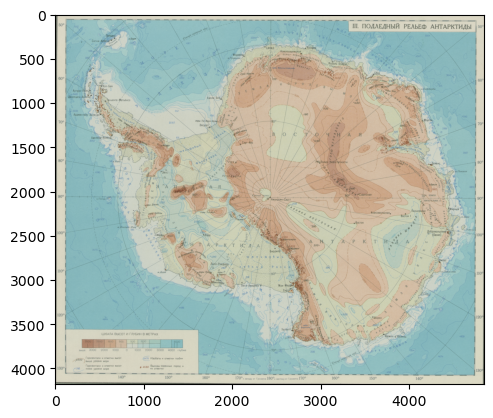

In [12]:
plt.imshow(array, interpolation=None)

In [13]:
import numpy as np
from skimage.filters import rank
from skimage.morphology import disk

def fast_circular_median_filter(array, radius=21):
    """
    Apply circular median filter to RGB image as fast as possible.
    Optimized for large images (tested up to 5000x5000).
    
    Args:
        array: numpy array of shape (H, W, 3) 
        radius: radius of circular footprint in pixels
        
    Returns:
        filtered array with same shape and dtype as input
    """
    original_dtype = array.dtype
    original_range = (array.min(), array.max())
    
    # Convert to uint8 for skimage rank filter (requirement for speed)
    if array.dtype != np.uint8:
        # Normalize to 0-255 range
        array_normalized = (array - original_range[0]) / (original_range[1] - original_range[0])
        array_uint8 = (array_normalized * 255).astype(np.uint8)
    else:
        array_uint8 = array
    
    # Create circular footprint
    footprint = disk(radius)
    
    # Pre-allocate output
    filtered_uint8 = np.empty_like(array_uint8)
    
    # Apply median filter to each channel
    for channel in range(3):
        filtered_uint8[:, :, channel] = rank.median(
            array_uint8[:, :, channel], 
            footprint=footprint
        )
    
    # Convert back to original dtype and range if needed
    if original_dtype != np.uint8:
        filtered_normalized = filtered_uint8.astype(np.float64) / 255.0
        filtered_array = (filtered_normalized * (original_range[1] - original_range[0]) + 
                         original_range[0]).astype(original_dtype)
    else:
        filtered_array = filtered_uint8
    
    return filtered_array


# For even larger images (5000x5000+), add parallel processing option
from concurrent.futures import ThreadPoolExecutor

def fast_circular_median_filter_parallel(array, radius=21, n_workers=3):
    """
    Parallel version for very large images.
    Each RGB channel processed in parallel.
    
    Best for images > 3000x3000 pixels.
    """
    original_dtype = array.dtype
    original_range = (array.min(), array.max())
    
    # Convert to uint8
    if array.dtype != np.uint8:
        array_normalized = (array - original_range[0]) / (original_range[1] - original_range[0])
        array_uint8 = (array_normalized * 255).astype(np.uint8)
    else:
        array_uint8 = array
    
    footprint = disk(radius)
    filtered_uint8 = np.empty_like(array_uint8)
    
    def process_channel(channel_idx):
        return rank.median(array_uint8[:, :, channel_idx], footprint=footprint)
    
    # Process channels in parallel
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(executor.map(process_channel, range(3)))
    
    for channel, result in enumerate(results):
        filtered_uint8[:, :, channel] = result
    
    # Convert back to original dtype
    if original_dtype != np.uint8:
        filtered_normalized = filtered_uint8.astype(np.float64) / 255.0
        filtered_array = (filtered_normalized * (original_range[1] - original_range[0]) + 
                         original_range[0]).astype(original_dtype)
    else:
        filtered_array = filtered_uint8
    
    return filtered_array


# Simple wrapper that automatically chooses best method
def median_filter_auto(array, radius=21, size_threshold=3000):
    """
    Automatically choose fastest method based on image size.
    
    Args:
        array: RGB array (H, W, 3)
        radius: filter radius in pixels
        size_threshold: use parallel version above this size
    """
    max_dim = max(array.shape[0], array.shape[1])
    
    if max_dim > size_threshold:
        return fast_circular_median_filter_parallel(array, radius)
    else:
        return fast_circular_median_filter(array, radius)


In [14]:
import numpy as np

def create_depth_lookup():
    """
    Create RGB to depth mapping for topographic map.
    Returns dict mapping (R,G,B) tuples to depth values.
    """
    # Define RGB -> depth mapping (using midpoint of ranges)
    depth_map = {
        # Land
        (172, 126, 99): 3500,      # 3000+ (using 3500 as representative)
        (180, 140, 113): 2500,     # 2000-3000
        (198, 162, 129): 1500,     # 1000-2000
        (205, 181, 155): 500,      # 0-1000
        (197, 203, 175): -500,     # -1000-0
        (169, 189, 174): -1500,    # -2000--1000
        (152, 190, 177): -2500,    # -3000--2000
        
        # Ocean
        (202, 206, 192): -500,     # -1000-0
        (177, 201, 194): -1500,    # -2000--1000
        (150, 194, 188): -2500,    # -3000--2000
        (131, 184, 186): -3500,    # -4000--3000
        (120, 177, 184): -4500,    # -4000+ (using -4500 as representative)
    }
    
    return depth_map



def rgb_to_depth_vectorized(rgb_array, depth_map=None):
    """
    Vectorized version - fastest for large images.
    Uses broadcasting for maximum speed.
    """
    if depth_map is None:
        depth_map = create_depth_lookup()
    
    # Convert to arrays for vectorized operations
    rgb_keys = np.array(list(depth_map.keys()), dtype=np.uint8)  # (N, 3)
    depth_values = np.array(list(depth_map.values()), dtype=np.float32)  # (N,)
    
    # Reshape arrays for broadcasting
    # rgb_array: (H, W, 3) -> (H, W, 1, 3)
    # rgb_keys: (N, 3) -> (1, 1, N, 3)
    rgb_expanded = rgb_array[:, :, np.newaxis, :].astype(np.float32)
    keys_expanded = rgb_keys[np.newaxis, np.newaxis, :, :].astype(np.float32)
    
    # Calculate distances to all reference colors at once
    distances = np.sqrt(np.sum((rgb_expanded - keys_expanded)**2, axis=3))  # (H, W, N)
    
    # Find nearest color for each pixel
    nearest_indices = np.argmin(distances, axis=2)  # (H, W)
    
    # Map to depth values
    depth_array = depth_values[nearest_indices]
    
    return depth_array


In [15]:
filtered = median_filter_auto(array, radius=32)

In [16]:
depth = rgb_to_depth_vectorized(filtered)

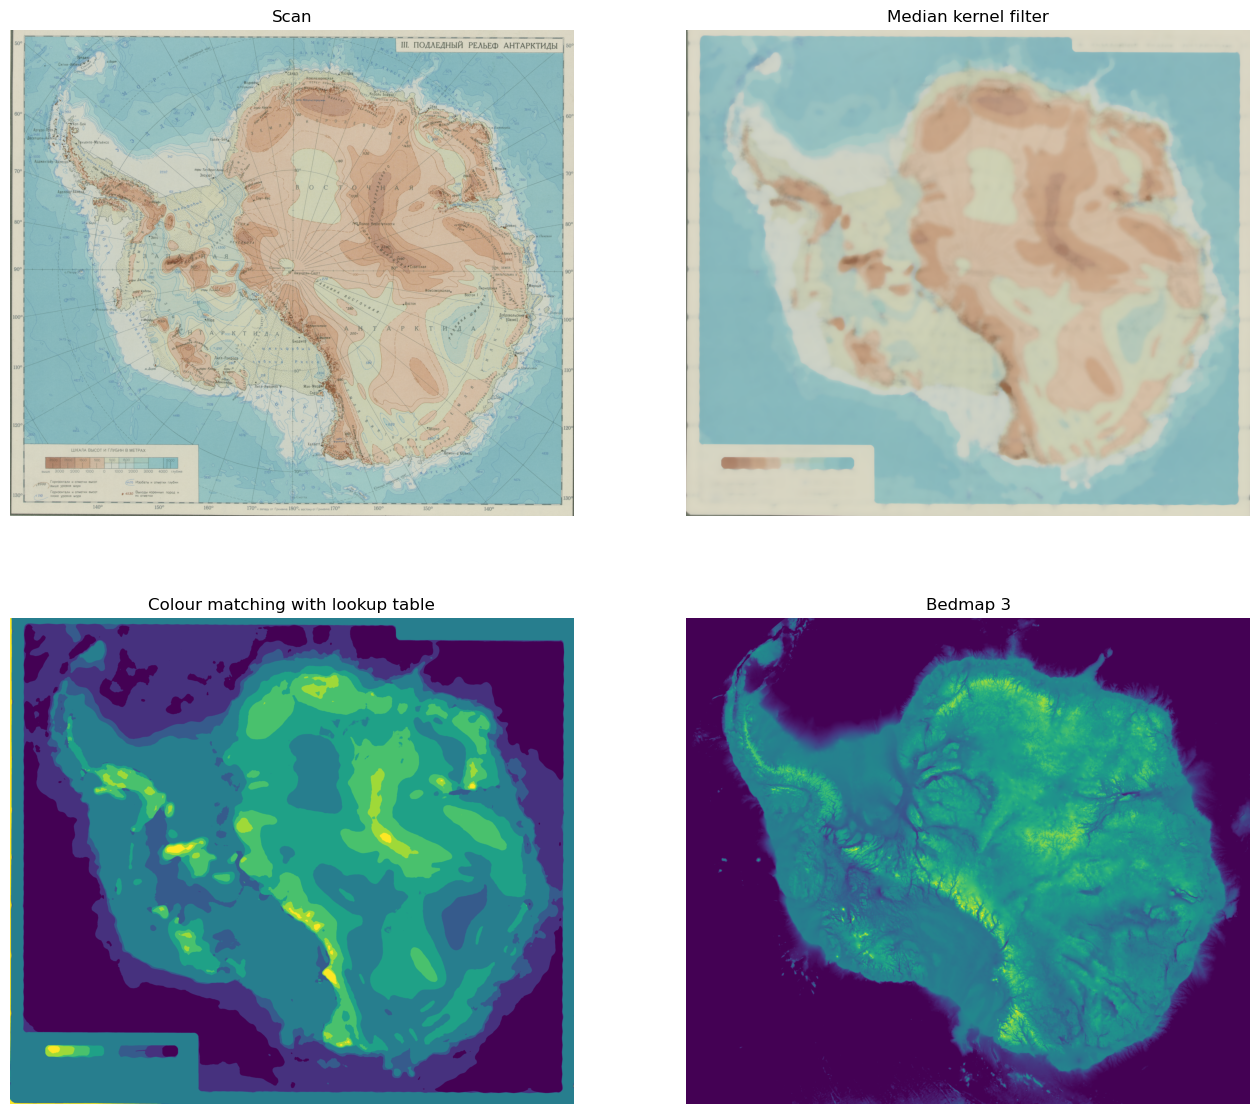

In [17]:
vmin = -3500
vmax = 3500


fig, ax = plt.subplots(2, 2, figsize = (16, 14))
ax[0,0].imshow(array)
ax[0,1].imshow(filtered)
ax[1,0].imshow(depth, vmin = vmin, vmax = vmax)
ax[1,1].imshow(bm3_array_aa, vmin = vmin, vmax = vmax)

ax[0,0].set_title('Scan')
ax[0,1].set_title('Median kernel filter')
ax[1,0].set_title('Colour matching with lookup table')
ax[1,1].set_title('Bedmap 3')

for a in ax.flatten():
    a.axis('off')
    a.set_xticks([])
    a.set_yticks([])
    a.set_frame_on(False)

fig.savefig('fig/fig_s10.pdf')